# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


# Install

In [ ]:
! pip install spectral_cube

# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from scipy.signal import savgol_filter, convolve, windows

import torch

from pathlib import Path

from spectral_cube import SpectralCube

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
dust3d_data_path = data_path / 'dust3d'
dust3d_spectra_path = dust3d_data_path / 'spectra'

gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'



GASS_data_path = ml_data_path / 'GASS'

hi_dust_data_file = dust3d_data_path / 'hi_dust_distances_full.npz'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

# Fcn

In [ ]:
def read_fits_cube(filename):
    """
    Read

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """

    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube

    # c = c[:, 10:29, 10:29]

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header
    # w = WCS(hdr)

    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close()  # Close the FITS file - we already read it in and don't need it anymore!

    print(f"Cube shape: {c.shape}") # (vlsr, b, l) : (971, 201, 376)

    del dat
    # cube = cube.with_spectral_unit(u.km / u.s)

    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]     # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]    # extract velocity

    return c, w, x, y, v, hdr

In [ ]:
vlsr_sun = 15.17 # km/s, see GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 500)

# Define the Gaussian function
def gaussian(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

# For plotting

In [ ]:

# Circle
def _circle(x, y, r):
    theta = np.linspace(0, 2*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_LMC = 279.
gb_LMC = -33.5
R_LMC = 5.

gl_SMC = 302.
gb_SMC = -44.5
R_SMC = 3.

LMC = dict(
    gl = gl_LMC,
    gb = gb_LMC,
    center = [gl_LMC, gb_LMC],
    glon_range = [270., 307.],
    glat_range = [-48., -25.],
    circ = _circle(gl_LMC, gb_LMC, R_LMC),
    name = 'Large Magellanic Cloud'
)


SMC = dict(
    gl = gl_SMC,
    gb = gb_SMC,
    center = [gl_SMC, gb_SMC],
    glon_range = [295., 315.],
    glat_range = [-50., -40.],
    circ = _circle(gl_SMC, gb_SMC, R_SMC),
    name = 'Small Magellanic Cloud'
)


# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = SMC['circ']
LMC_xcirc, LMC_ycirc = LMC['circ']

# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of all sources 2714


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
8,24,J004327-704135,SB30665_component_11a,10.863942,-70.693260,303.888848,-46.420157,B,215.136993,332.138000,...,5.895,131.210007,2.227711e+20,False,0.000643,M344-11,30665,30665,False,False
10,26,J013229-723956,SB30665_component_12a,23.123198,-72.665757,298.690805,-44.122841,B,138.602005,138.981995,...,4.800,127.029999,1.083733e+21,False,0.002100,M344-06,30665,30665,False,False
11,28,J002919-754018,SB30665_component_13a,7.330447,-75.671738,304.752927,-41.378221,B,185.477005,206.205994,...,4.860,7.050000,1.705849e+20,False,0.002592,M344-11,30665,30665,False,False
12,29,J002920-754008,SB30665_component_13b,7.334793,-75.668999,304.751919,-41.381065,B,70.438004,70.567001,...,4.735,156.479996,1.705849e+20,False,0.000732,M344-11,30665,30665,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709,0,J045631-762533,SB38845_component_245a,74.132371,-76.425960,288.737278,-32.932020,C,18.582001,20.014000,...,4.195,40.980000,0.000000e+00,False,-0.001994,M000-02,"38509,38845",38845,False,False
2710,0,J045907-753153,SB38845_component_261a,74.779860,-75.531478,287.674258,-33.105855,C,17.294001,21.070000,...,4.570,51.529999,0.000000e+00,False,-0.000745,M000-02,"38758,38845",38845,False,False
2711,0,J045340-751015,SB38758_component_264a,73.419855,-75.170876,287.418567,-33.556039,C,15.995000,17.537001,...,4.195,57.150002,0.000000e+00,False,0.004325,M000-02,"38758,38845",38758,False,False
2712,0,J060302-715904,SB33047_component_273a,90.760142,-71.984682,282.615941,-29.427549,C,16.532000,17.809999,...,3.845,84.059998,0.000000e+00,False,-0.017450,M000-02,"33047,38845",33047,False,False


# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/result_table_dr3_integrated_properties.csv
Number of rows 462,
 Number of columns: 45


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,flux_int,ra_hr,tau_noise_per_channel
0,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,...,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342,179.488998,0.240077,0.014621
1,J002144-741500,30665,J002144-741500-30665,5.433208,-74.249829,305.669096,-42.720187,0,B,122.134003,...,0.139190,3.164146,0.399856,3.152547,0.179060,2,3.561425,132.397995,0.362214,0.028466
2,J002223-742825,30665,J002223-742825-30665,5.597676,-74.473760,305.562542,-42.505801,0,B,103.077003,...,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425,206.740997,0.373178,0.019057
3,J002248-734007,30665,J002248-734007-30665,5.700254,-73.668709,305.692177,-43.305728,0,B,49.626999,...,0.084394,3.155461,0.213848,2.971679,0.125477,1,3.564467,49.803001,0.380017,0.057622
4,J002335-735529,30665,J002335-735529-30665,5.895892,-73.924770,305.565463,-43.060758,0,B,62.061001,...,0.093914,2.635446,0.234640,2.824470,0.128897,1,3.567508,61.556000,0.393059,0.018767


In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

In [ ]:
df_cnm[df_cnm['cencnm'] < -15.]

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
51,J044512-654707,38373,J044512-654707-38373,71.30335,-65.785523,276.844078,-37.365553,0,B,131.518005,...,0.534026,0.329702,0.019492,0.103666,0.006873,3.180426,0.095409,3.293769,0.328933,0.038879


# HI absorption vs dust spectra

In [ ]:
hi_abs_srcs = df_det.comp_name.to_list()
len(hi_abs_srcs)

462

In [ ]:
dri = 1.
dust_dist = np.arange(69., 1251., dri)
print(dust_dist.shape)
dust_dist

(1182,)


array([  69.,   70.,   71., ..., 1248., 1249., 1250.])

In [ ]:
dri = 0.496218487394958
dust_dist = np.arange(69., 1250.+dri, dri)
print(dust_dist.shape)
dust_dist

(2381,)


array([  69.        ,   69.49621849,   69.99243697, ..., 1249.00756303,
       1249.50378151, 1250.        ])

In [ ]:
hi_tau_max_vlsr_arr = []
hi_tb_max_vlsr_arr = []
dust_tau_max_dist_arr = []

for hi_det_src_id in range(462):

    # GASKAP source
    gaskap_src = df_det.iloc[hi_det_src_id]

    gaskap_src_name = gaskap_src.comp_name
    gaskap_field = gaskap_src.sbid

    nhi = gaskap_src.nhi
    sig_nhi = gaskap_src.signhi
    nhi_thin = gaskap_src.nhi_thin

    src_glon = gaskap_src.glon
    src_glat = gaskap_src.glat

    # HI data: Open and load the pickle file
    gaskap_src_file = gaskap_hires_result_path / ('sb'+str(gaskap_field)) / f'{gaskap_src_name}.pkl'


    with open(gaskap_src_file, 'rb') as f:
        gaskap_res_data = pickle.load(f)


    gaskap_em_closest_em_profile = gaskap_res_data['EM_profiles'][:, 0]
    gaskap_em_avg_em_profile = np.mean(gaskap_res_data['EM_profiles'], axis=1)





    vlsr_gaskap = gaskap_res_data['vlsr_gaskap']
    sigemt_gaskap = gaskap_res_data['sigemt']
    emt_gaskap = gaskap_res_data['emt']

    idx_tb_max = np.nanargmax(gaskap_em_avg_em_profile)
    tb_max_vlsr = vlsr_gaskap[idx_tb_max]

    ncnm = gaskap_res_data['ncnm']
    hgtcnm = gaskap_res_data['hgtcnm']
    cencnm = gaskap_res_data['cencnm']
    widcnm = gaskap_res_data['widcnm']

    idx_sorted = np.argsort(hgtcnm, )
    hgtcnm = hgtcnm[idx_sorted]
    cencnm = cencnm[idx_sorted]
    widcnm = widcnm[idx_sorted]

    tau_max_vlsr = cencnm[-1]

    # compute sum of gaussians
    hi_tau_arr = np.zeros_like(vlsr_gaskap)
    for i in range(ncnm):
        hi_tau_arr += gaussian(vlsr_gaskap, hgtcnm[i], cencnm[i], widcnm[i])




    # Dust spectra
    outfile = dust3d_spectra_path / (gaskap_src_name + '.npy')
    dspeci = np.load(outfile)


    #
    idx_max = np.nanargmax(dspeci)
    dtau_max_disti = dust_dist[idx_max]
    print('Vlsr, tb_max_vlsr <-> D: ', tau_max_vlsr, tb_max_vlsr, dtau_max_disti)



    hi_tau_max_vlsr_arr.append(tau_max_vlsr)
    dust_tau_max_dist_arr.append(dtau_max_disti)
    hi_tb_max_vlsr_arr.append(tb_max_vlsr)

<>:102: SyntaxWarning: invalid escape sequence '\m'
<>:102: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3377611622.py:102: SyntaxWarning: invalid escape sequence '\m'
  ax.axvline(x=tau_max_vlsr, color='k', ls=':', zorder=1, lw=2, label='CNM component $V_\mathrm{0,CNM}$')


Vlsr, tb_max_vlsr <-> D:  -1.02433119692662 -1.3663471372306617 219.35420168067145
Vlsr, tb_max_vlsr <-> D:  -1.0199476167303299 -0.3964224782419805 209.92605042016731
Vlsr, tb_max_vlsr <-> D:  -2.681593382007805 -0.3964224782419805 220.3466386554614
Vlsr, tb_max_vlsr <-> D:  -1.7374672654668823 -1.3663471372306617 217.8655462184866
Vlsr, tb_max_vlsr <-> D:  -0.6188510168660115 -0.3964224782419805 211.91092436974714
Vlsr, tb_max_vlsr <-> D:  -0.5655401491340981 -0.3964224782419805 211.91092436974714
Vlsr, tb_max_vlsr <-> D:  -1.9896830337500109 -1.3663471372306617 216.8731092436967
Vlsr, tb_max_vlsr <-> D:  2.3142427694812833 2.51335149872407 213.399579831932
Vlsr, tb_max_vlsr <-> D:  2.8816173625645556 2.51335149872407 213.399579831932
Vlsr, tb_max_vlsr <-> D:  0.5065272321224947 0.5735021807467007 217.8655462184866
Vlsr, tb_max_vlsr <-> D:  -2.835171335558361 -1.3663471372306617 217.8655462184866
Vlsr, tb_max_vlsr <-> D:  -1.1530544882846334 -0.3964224782419805 215.88067226890678
Vls

In [ ]:

vlsr_dist_dict_file = dust3d_data_path / 'hi_vlsr_3d_dust.pkl'
# with open(vlsr_dist_dict_file, 'wb') as f:
#     pickle.dump(vlsr_dist_dict, f)


with open(vlsr_dist_dict_file, 'rb') as f:
    vlsr_dist_dict = pickle.load(f)

vlsr_dist_dict.keys()

hi_tau_max_vlsr_arr = vlsr_dist_dict['vlsr']
hi_tb_max_vlsr_arr = vlsr_dist_dict['tb_vlsr']
dust_tau_max_dist_arr = vlsr_dist_dict['distances']

# 3D dust vs HI

In [ ]:
print(dust3d_data_path)
ppd_data_file = dust3d_data_path / 'Nguyen2025_L267.52to307.6_B-55.1to-15.02_pxsz6.87arcmin_d70.0to1244.7_vLSR-24.4to24.6_E24ppd.fits'
print(ppd_data_file)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/dust3d
/content/gdrive/MyDrive/Colab Notebooks/gaia/data/dust3d/Nguyen2025_L267.52to307.6_B-55.1to-15.02_pxsz6.87arcmin_d70.0to1244.7_vLSR-24.4to24.6_E24ppd.fits


In [ ]:
ppd_data, ppd_hdr = fits.getdata(ppd_data_file, header=True)

In [ ]:
ppd_hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  350                                                  
NAXIS2  =                  350                                                  
NAXIS3  =                  516                                                  
EXTEND  =                    T                                                  
CRVAL1  =                287.5                                                  
CDELT1  = -0.11451621372724687                                                  
CRPIX1  =                175.0                                                  
CTYPE1  = 'GLON-TAN'                                                            
CUNIT1  = 'deg     '                                                            
CRVAL2  =                -35

In [ ]:
# Create WCS object
w_dist = WCS(ppd_hdr)

# Method 1: Using WCS to get coordinate arrays
# Create pixel coordinate arrays
naxis1, naxis2, naxis3 = ppd_hdr['NAXIS1'], ppd_hdr['NAXIS2'], ppd_hdr['NAXIS3']

# Pixel coordinates (0-indexed)
x_pix = np.arange(naxis1)  # GLON pixel coordinates
y_pix = np.arange(naxis2)  # GLAT pixel coordinates
z_pix = np.arange(naxis3)  # Velocity pixel coordinates

# Convert to world coordinates
# For 1D arrays, we need to create coordinate grids
glon_axis = w_dist.wcs_pix2world(x_pix, np.zeros_like(x_pix), np.zeros_like(x_pix), 0)[0]
glat_axis = w_dist.wcs_pix2world(np.zeros_like(y_pix), y_pix, np.zeros_like(y_pix), 0)[1]
dist_axis = w_dist.wcs_pix2world(np.zeros_like(z_pix), np.zeros_like(z_pix), z_pix, 0)[2]
dist_axis = 10**dist_axis

print("Distance axis (pc):", dist_axis)
print(dist_axis.shape)
print(np.argmin(np.abs(dist_axis - 220.32266)))

In [ ]:
w2D_dist = w_dist.celestial
w2D_dist

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.5 -35.0 
CRPIX : 175.0 175.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.11451621372724687 0.11451621372724687 
NAXIS : 350  350

In [ ]:
# Distance axis
pixel_index = 516
dist_val = ppd_hdr['CRVAL3'] + ppd_hdr['CDELT3'] * (pixel_index + 1 - ppd_hdr['CRPIX3'])
print(dist_val, 10**(dist_val))

3.0999320745468135 1258.7285260501938


In [ ]:
print(dust3d_data_path)
ppv_data_file = dust3d_data_path / 'Nguyen2025_L267.52to307.6_B-55.1to-15.02_pxsz6.87arcmin_d70.0to1244.7_vLSR-24.4to24.6_HI4PIppv.fits'
print(ppv_data_file)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/dust3d
/content/gdrive/MyDrive/Colab Notebooks/gaia/data/dust3d/Nguyen2025_L267.52to307.6_B-55.1to-15.02_pxsz6.87arcmin_d70.0to1244.7_vLSR-24.4to24.6_HI4PIppv.fits


In [ ]:
ppv_data, ppv_hdr = fits.getdata(ppv_data_file, header=True)
ppv_hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  350                                                  
NAXIS2  =                  350                                                  
NAXIS3  =                   47                                                  
EXTEND  =                    T                                                  
CRVAL1  =                287.5                                                  
CDELT1  = -0.11451621372724687                                                  
CRPIX1  =                175.0                                                  
CTYPE1  = 'GLON-TAN'                                                            
CUNIT1  = 'deg     '                                                            
CRVAL2  =                -35

In [ ]:
# Create WCS object
vel_w = WCS(ppv_hdr)

# Method 1: Using WCS to get coordinate arrays
# Create pixel coordinate arrays
naxis1, naxis2, naxis3 = ppv_hdr['NAXIS1'], ppv_hdr['NAXIS2'], ppv_hdr['NAXIS3']

# Pixel coordinates (0-indexed)
x_pix = np.arange(naxis1)  # GLON pixel coordinates
y_pix = np.arange(naxis2)  # GLAT pixel coordinates
z_pix = np.arange(naxis3)  # Velocity pixel coordinates

# Convert to world coordinates
# For 1D arrays, we need to create coordinate grids
glon_axis = vel_w.wcs_pix2world(x_pix, np.zeros_like(x_pix), np.zeros_like(x_pix), 0)[0]
glat_axis = vel_w.wcs_pix2world(np.zeros_like(y_pix), y_pix, np.zeros_like(y_pix), 0)[1]
vel_axis = vel_w.wcs_pix2world(np.zeros_like(z_pix), np.zeros_like(z_pix), z_pix, 0)[2]
vel_axis = vel_axis/1000.

print("GLON axis (degrees):", glon_axis)
print("GLAT axis (degrees):", glat_axis)
print("Velocity axis (m/s):", vel_axis)
print(vel_axis.shape)
print(np.argmin(np.abs(vel_axis - 2.7)))

In [ ]:
w2D_vel = vel_w.celestial
w2D_vel

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.5 -35.0 
CRPIX : 175.0 175.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.11451621372724687 0.11451621372724687 
NAXIS : 350  350

In [ ]:
pixel_index = 47
vel_val = ppv_hdr['CRVAL3'] + ppv_hdr['CDELT3'] * (pixel_index + 1 - ppv_hdr['CRPIX3'])
print(vel_val, vel_val/1000.)

32306.331631109162 32.30633163110916


In [ ]:
hi3d_data = np.load(hi_dust_data_file)
hi3d_data.keys()

KeysView(NpzFile '/content/gdrive/MyDrive/Colab Notebooks/gaia/data/dust3d/hi_dust_distances_full.npz' with keys: ppdcube, ppdhdr, ppvcube, ppvhdr, Vd...)

In [ ]:
distmat = hi3d_data['distmat'].flatten()
vlsrmat = hi3d_data['vlsrmat'].flatten()
vscore = hi3d_data['Vd'].flatten()
v0score = hi3d_data['V'].flatten()

In [ ]:
# Find the index of the maximum value in flattened array
flat_index = np.argmax(vscore)

# Convert the flat index to 2D coordinates
max_indices = np.unravel_index(flat_index, hi3d_data['Vd'].shape)

print(f"Maximum value: {hi3d_data['Vd'][max_indices]}")
print(f"Indices of maximum value: {max_indices}")

Maximum value: 63.05889287527397
Indices of maximum value: (np.int64(204), np.int64(21))


In [ ]:
distmat[flat_index]

np.float64(220.32266806498973)

In [ ]:
vlsrmat[flat_index]

np.float64(2.677387341253714)

In [ ]:
# Find the index of the maximum value in flattened array
flat_index0 = np.argmax(v0score)

# Convert the flat index to 2D coordinates
max_indices = np.unravel_index(flat_index0, hi3d_data['V'].shape)

print(f"Maximum value: {hi3d_data['V'][max_indices]}")
print(f"Indices of maximum value: {max_indices}")

Maximum value: 23.67275506903942
Indices of maximum value: (np.int64(204), np.int64(21))


In [ ]:
vel_pixel_index = 24
vel_val = ppv_hdr['CRVAL3'] + ppv_hdr['CDELT3'] * (vel_pixel_index + 1 - ppv_hdr['CRPIX3'])
print(vel_val, vel_val/1000.)

2677.387341253714 2.677387341253714


In [ ]:
# Distance axis
dist_pixel_index = 206
dist_val = ppd_hdr['CRVAL3'] + ppd_hdr['CDELT3'] * (dist_pixel_index + 1 - ppd_hdr['CRPIX3'])
print(dist_val, 10**(dist_val))

2.3430591821670532 220.32266806498973


In [ ]:
distmat[flat_index0]

np.float64(220.32266806498973)

In [ ]:
vlsrmat[flat_index0]

np.float64(2.677387341253714)

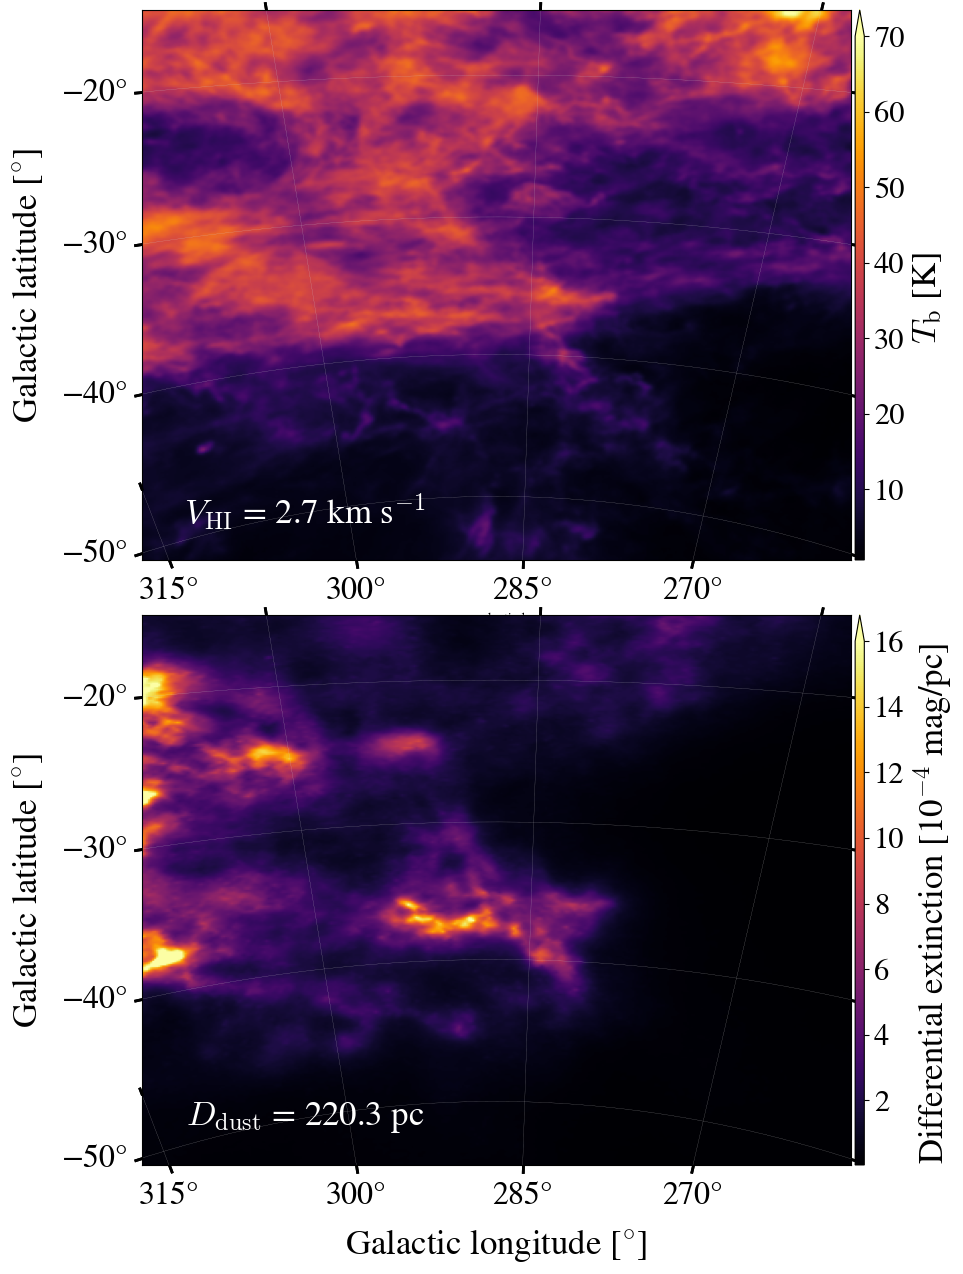

In [ ]:
xlbs = 25
tlbs = 23
cmap = 'viridis'

cm = mpl.colormaps['cool'] # winter, cool, hsv, jet


# Plot
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(211, projection=w2D_vel)

# Display the moment map image
im = ax.imshow(hi3d_data['ppvcube'][vel_pixel_index, :, :], cmap='inferno', origin='lower', vmax=70., aspect='auto')
ax.text(80, 30, r'$V_\mathrm{HI}$ = 2.7 km s$^{-1}$', dict(size=25, color='white'), horizontalalignment='center',  verticalalignment='center', ) # transform=ax.get_transform('galactic')



# Add axes labels
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=xlbs)

# Color bar
cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', fraction=0.08, pad=0.006, aspect=60)
cbar.ax.set_ylabel(r'$T_\mathrm{b}$ [K]', rotation=90, labelpad=5., fontsize=xlbs)
cbar.ax.tick_params(labelsize=22)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)






################

ax = fig.add_subplot(212, projection=w2D_dist)

dxfactor = 2.8 * 5.8e21 # See section 2.1, below Fig 3, https://www.aanda.org/articles/aa/pdf/2025/03/aa53022-24.pdf

# Display image
im = ax.imshow(1.e4*hi3d_data['ppdcube'][dist_pixel_index, :, :]/dxfactor, cmap='inferno', origin='lower', vmax=16., aspect='auto')

ax.text(80, 30, r'$D_\mathrm{dust}$ = 220.3 pc', dict(size=25, color='white'), horizontalalignment='center',  verticalalignment='center', ) # transform=ax.get_transform('galactic')


# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=xlbs)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=xlbs)

# Color bar
cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', fraction=0.08, pad=0.006, aspect=60)
cbar.ax.set_ylabel(r'Differential extinction [10$^{-4}$ mag/pc]', rotation=90, labelpad=5., fontsize=xlbs)
cbar.ax.tick_params(labelsize=22)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)



# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.1
                    )



plt.show()

In [ ]:
# Create a grid for interpolation
Z0i = griddata((distmat, vlsrmat), v0score, (Xi, Yi), method='cubic')

# Find the indices of the maximum values along axis 0 of Z
max_indices_Z = np.argmax(hi3d_data['Vd'], axis=1)

# Find the indices of the maximum values along axis 0 of Z
max_indices_Z0 = np.argmax(hi3d_data['V'], axis=1)

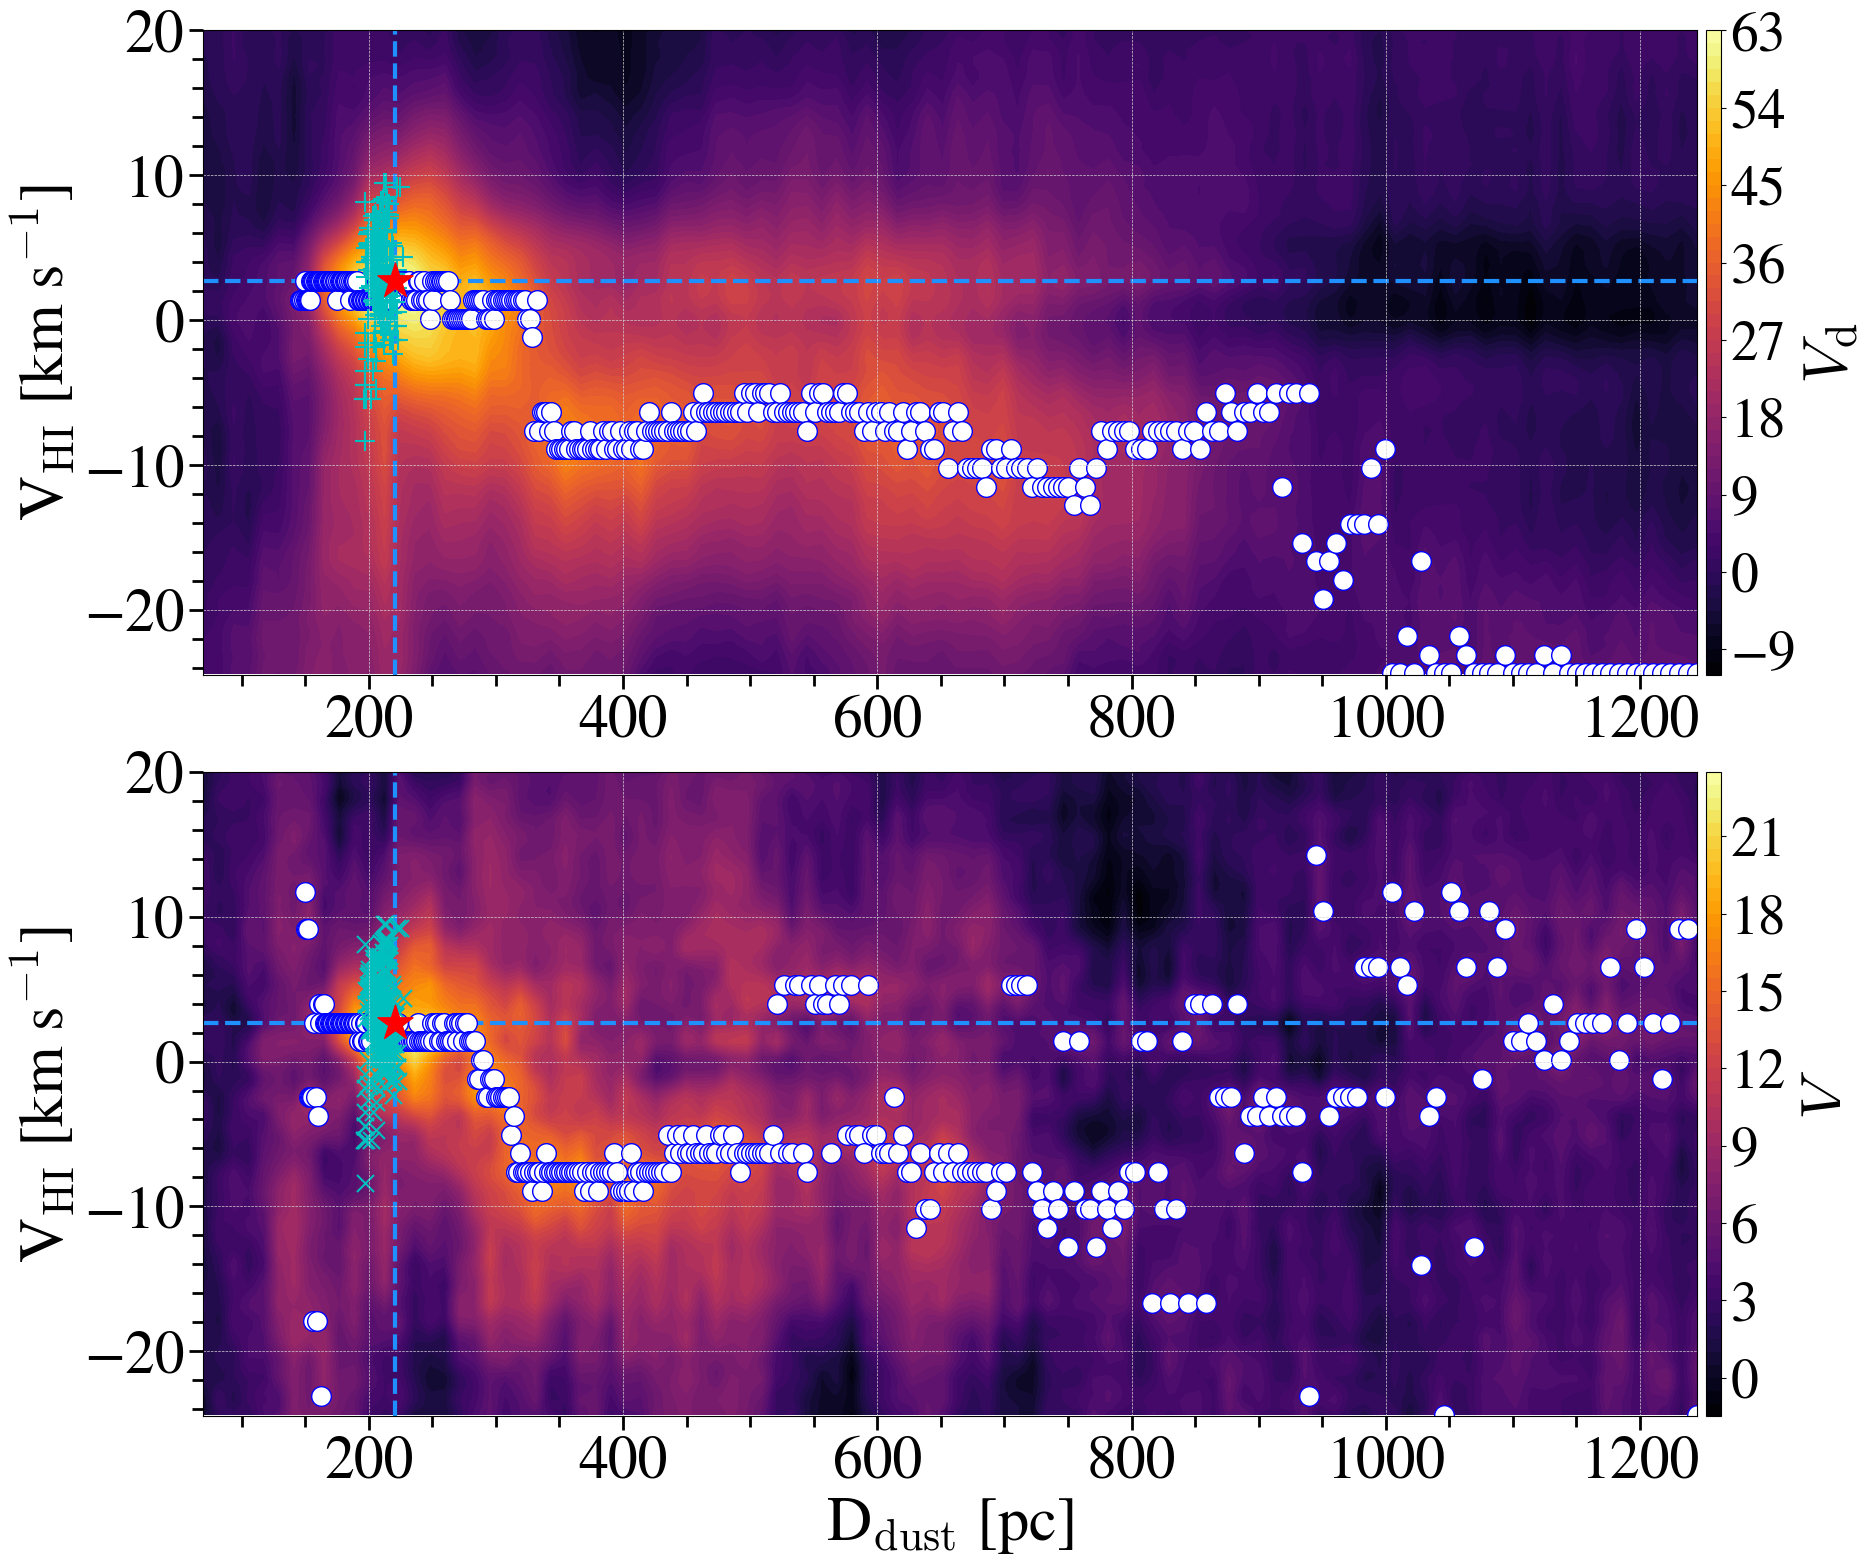

In [ ]:
labelsize = 43
xylabelsize = 45

# Plot
fig = plt.figure(figsize=(20,18))

# cm = mpl.cm.get_cmap('cool') # winter, cool, hsv

ax = plt.subplot(211)


# Create contour plot
contour = ax.contourf(Xi, Yi, Zi, 60, cmap='inferno') #coolwarm
ax.scatter(vlsrmat, distmat, c='white', s=10, alpha=0.5)  # Show original points

ax.scatter(distmat[flat_index], vlsrmat[flat_index], zorder=3, s=700, marker='*',
                 c='r',
                 label=f'')

# Extract the X and Y coordinates corresponding to the maximum Z values
X_max_Z = hi3d_data['distmat'][np.arange(hi3d_data['distmat'].shape[0]), max_indices_Z]
Y_max_Z = hi3d_data['vlsrmat'][np.arange(hi3d_data['distmat'].shape[0]), max_indices_Z]

X_max_Z[X_max_Z < 146.] = np.nan
Y_max_Z[X_max_Z < 146.] = np.nan

ax.axvline(x=distmat[flat_index], color='dodgerblue', ls='--', lw=3, zorder=1, label='')
ax.axhline(y=vlsrmat[flat_index], color='dodgerblue', ls='--', lw=3, zorder=1, label='')

# Mark these maximum locations on the X-Y plot
ax.scatter(X_max_Z, Y_max_Z, color='w', marker='o', s=200, zorder=1, edgecolors='b', label='')



ax.scatter(dust_tau_max_dist_arr, hi_tb_max_vlsr_arr, zorder=1, s=200, marker='+',
                 c='c',
                 label=f'')



# Add axes labels
ax.set_ylabel(r'V$_\mathrm{HI}$ [km s$^{-1}$]', fontsize=xylabelsize, fontweight='normal')


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=labelsize, pad=4)
ax.tick_params(axis='y', labelsize=labelsize)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=8)

ax.set_xlim(69.5, 1245.)
ax.set_ylim(-24.5, 20.)


# Color bar
cbar = fig.colorbar(contour, ax=ax, orientation='vertical', fraction=0.03, pad=0.006, aspect=45)
cbar.ax.set_ylabel(r'$V_\mathrm{d}$', rotation=90, labelpad=5., fontsize=xylabelsize)
cbar.ax.tick_params(labelsize=40)


ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)








############
# Axis
ax = plt.subplot(212)


# Create contour plot
contour = ax.contourf(Xi, Yi, Z0i, 60, cmap='inferno')
ax.scatter(vlsrmat, distmat, c='white', s=10, alpha=0.5)

ax.scatter(distmat[flat_index], vlsrmat[flat_index], zorder=3, s=700, marker='*',
                 c='r',
                 label=f'')



ax.axvline(x=distmat[flat_index0], color='dodgerblue', ls='--', lw=3, zorder=1, label='')
ax.axhline(y=vlsrmat[flat_index0], color='dodgerblue', ls='--', lw=3, zorder=1, label='')







# Extract the X and Y coordinates corresponding to the maximum Z values
X_max_Z0 = hi3d_data['distmat'][np.arange(hi3d_data['distmat'].shape[0]), max_indices_Z0]
Y_max_Z0 = hi3d_data['vlsrmat'][np.arange(hi3d_data['distmat'].shape[0]), max_indices_Z0]

X_max_Z0[X_max_Z0 < 149.] = np.nan
Y_max_Z0[X_max_Z0 < 149.] = np.nan

# Mark these maximum locations on the X-Y plot
ax.scatter(X_max_Z0, Y_max_Z0, color='w', marker='o', s=200, zorder=1, edgecolors='b', label='')


ax.scatter(dust_tau_max_dist_arr, hi_tb_max_vlsr_arr, zorder=1, s=150, marker='x',
                 c='c',
                 label=f'')



ax.set_xlabel(r'D$_\mathrm{dust}$ [pc]', fontsize=xylabelsize)
ax.set_ylabel(r'V$_\mathrm{HI}$ [km s$^{-1}$]', fontsize=xylabelsize, fontweight='normal')

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=labelsize, pad=4)
ax.tick_params(axis='y', labelsize=labelsize)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=8)

ax.set_xlim(69.5, 1245.)
ax.set_ylim(-24.5, 20.)

# Color bar
cbar = fig.colorbar(contour, ax=ax, orientation='vertical', fraction=0.03, pad=0.006, aspect=45)
cbar.ax.set_ylabel(r'$V_\mathrm{}$', rotation=90, labelpad=5., fontsize=xylabelsize)
cbar.ax.tick_params(labelsize=40)


ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.15
                    )

plt.show()